### **INDEX**
1. Setup notebook
2. Data cleaning & preparation
3. Clustering: elbow technique and k-means
4. Research findings

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### **1. SETUP NOTEBOOK**

In [4]:
# import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sklearn 
from sklearn import preprocessing
from sklearn.impute import MissingIndicator
from sklearn.impute import  SimpleImputer
from sklearn.cluster import KMeans 
import pylab as pl

In [5]:
# activate inline matplotlib visuals 
%matplotlib inline

In [6]:
# get the current working directory as a Path object
path = Path.cwd()

# update the path to parent folder
parent_path = path.parent

In [7]:
# import lego data set
csv_file_path = parent_path / '2 Data' / 'Prepared data' / 'lego_analysis.csv'

# import data as datafram
df_lego_analysis = pd.read_csv(csv_file_path)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### **2. DATA CLEANING & PREPARATION**

In [10]:
df_lego_analysis.shape

(7815, 33)

In [11]:
df_lego_analysis.columns

Index(['Unnamed: 0', 'set_number', 'setID', 'name', 'year', 'theme',
       'themeGroup', 'subtheme', 'category', 'pieces', 'minifigs', 'ownedBy',
       'wantedBy', 'rating', 'reviewCount', 'packagingType', 'availability',
       'instructionsCount', 'minAge', 'US_retailPrice', 'UK_retailPrice',
       'CA_retailPrice', 'DE_retailPrice', 'PL_retailPrice', 'status',
       'year_time', 'year_period', 'set_num', 'theme_id', 'num_parts',
       'num_colors', 'num_materials', 'sum_spares'],
      dtype='object')

In [12]:
# subsetting numerical values only as a copy 
df_lego_num = df_lego_analysis[[
    'pieces', 'minifigs', 'ownedBy', 'wantedBy', 'rating', 'reviewCount', 
    'US_retailPrice', 'UK_retailPrice', 'CA_retailPrice', 'DE_retailPrice', 'PL_retailPrice', 
    'year_period', 'num_parts', 'num_colors', 'num_materials', 'sum_spares']].copy()

In [13]:
# normalizing retail prices for fair data interpretation
# get exchange rates in USD
exchange_rates = {
    'US_retailPrice': 1,  # USD (base currency)
    'UK_retailPrice': 1.36,  # Assuming 1 GBP = 1.36 USD
    'CA_retailPrice': 0.79,  # Assuming 1 CAD = 0.79 USD
    'DE_retailPrice': 1.18,  # Assuming 1 EUR = 1.18 USD
    'PL_retailPrice': 0.26   # Assuming 1 PLN = 0.26 USD
}

# normalize each market retail price by exchange rates + handling NaNs as 0
df_lego_num['US_normalized'] = df_lego_num['US_retailPrice'].fillna(0) * exchange_rates['US_retailPrice']
df_lego_num['UK_normalized'] = df_lego_num['UK_retailPrice'].fillna(0) * exchange_rates['UK_retailPrice']
df_lego_num['CA_normalized'] = df_lego_num['CA_retailPrice'].fillna(0) * exchange_rates['CA_retailPrice']
df_lego_num['DE_normalized'] = df_lego_num['DE_retailPrice'].fillna(0) * exchange_rates['DE_retailPrice']
df_lego_num['PL_normalized'] = df_lego_num['PL_retailPrice'].fillna(0) * exchange_rates['PL_retailPrice']

# create new column where average retail price across the 5 markets is calculated in dollars
df_lego_num['avg_rp'] = df_lego_num[['US_normalized', 'UK_normalized', 'CA_normalized', 'DE_normalized', 'PL_normalized']].mean(axis=1).round(2)

# drop retail price columns
df_lego_num.drop(columns=['US_retailPrice', 'UK_retailPrice', 'CA_retailPrice', 'DE_retailPrice', 'PL_retailPrice'], inplace=True)

In [14]:
# mark missing values
indicator = MissingIndicator(features="all")
missing_matrix = indicator.fit_transform(df_lego_num)

# transform array to df
missing_columns = df_lego_num.columns[indicator.features_]
missing_column_names = [f"{col}_missing" for col in missing_columns]
df_lego_missing = pd.DataFrame(missing_matrix, columns=missing_column_names, index=df_lego_num.index)

# subset missing values
df_lego_missing

,pieces_missing,minifigs_missing,ownedBy_missing,wantedBy_missing,rating_missing,reviewCount_missing,year_period_missing,num_parts_missing,num_colors_missing,num_materials_missing,sum_spares_missing,US_normalized_missing,UK_normalized_missing,CA_normalized_missing,DE_normalized_missing,PL_normalized_missing,avg_rp_missing
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,True,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7810,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7811,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7812,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7813,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
# imput missing values
# define columns to impute mean 
columns_mean = ['pieces', 'num_parts', 'num_colors', 'num_materials', 'sum_spares']

# use simpleimputer
imputer = SimpleImputer(strategy='mean')

# update df and add imputed values
df_lego_num[columns_mean] = imputer.fit_transform(df_lego_num[columns_mean])

# impute 0 for minifigs
mf_zero = SimpleImputer(strategy='constant', fill_value=0)

# update df and add imputed values
df_lego_num[['minifigs', 'ownedBy']] = mf_zero.fit_transform(df_lego_num[['minifigs', 'ownedBy']])

# confirm no more missing values
df_lego_num.isnull().sum()

pieces           0
minifigs         0
ownedBy          0
wantedBy         0
rating           0
reviewCount      0
year_period      0
num_parts        0
num_colors       0
num_materials    0
sum_spares       0
US_normalized    0
UK_normalized    0
CA_normalized    0
DE_normalized    0
PL_normalized    0
avg_rp           0
dtype: int64

In [16]:
# renaming columns
df_lego_num.rename(columns={
    'pieces': 'N.pieces', 
    'minifigs': 'N.minifigs', 
    'US_normalized': 'USnorm', 
    'UK_normalized': 'UKnorm', 
    'CA_normalized': 'CAnorm', 
    'DE_normalized': 'DEnorm', 
    'PL_normalized': 'PLnorm',
    'year_period': 'year',
    'num_parts': 'N.parts',
    'num_colors': 'N.colors',
    'num_materials': 'N.materials',
    'sum_spares': 'N.spares'                 
}, inplace=True)

In [17]:
# remove outliers using IQR
Q1 = df_lego_num.quantile(0.25)
Q3 = df_lego_num.quantile(0.75)
IQR = Q3 - Q1

# filter out outliers
df_lego_num = df_lego_num[~((df_lego_num < (Q1 - 1.5 * IQR)) | (df_lego_num > (Q3 + 1.5 * IQR))).any(axis=1)]

In [18]:
# confirm for scale no outliers
df_lego_num.describe().round(0)

,N.pieces,N.minifigs,ownedBy,wantedBy,rating,reviewCount,year,N.parts,N.colors,N.materials,N.spares,USnorm,UKnorm,CAnorm,DEnorm,PLnorm,avg_rp
count,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0,4319.0
mean,160.0,1.0,3857.0,1000.0,4.0,3.0,2015.0,160.0,12.0,1.0,65.0,15.0,17.0,14.0,12.0,23.0,16.0
std,167.0,1.0,2491.0,648.0,0.0,3.0,6.0,167.0,7.0,1.0,58.0,17.0,20.0,17.0,18.0,24.0,17.0
min,1.0,0.0,424.0,72.0,2.0,0.0,1997.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,34.0,0.0,1818.0,514.0,4.0,1.0,2012.0,33.0,6.0,1.0,19.0,0.0,0.0,0.0,0.0,4.0,2.0
50%,93.0,1.0,3164.0,804.0,4.0,2.0,2016.0,92.0,11.0,1.0,48.0,10.0,12.0,10.0,0.0,16.0,11.0
75%,244.0,2.0,5392.0,1334.0,4.0,4.0,2019.0,244.0,16.0,2.0,99.0,20.0,27.0,20.0,23.0,34.0,24.0
max,876.0,7.0,11285.0,3245.0,5.0,12.0,2023.0,876.0,33.0,3.0,291.0,80.0,98.0,71.0,71.0,145.0,73.0


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

**PREP DATA FOR TABLEAU**

In [21]:
# create flag for franchise sets
# franchise collection
franchise_themes = ['Avatar', 'Cars', 'Pirates of the Caribbean', 'The Lone Ranger', 'Toy Story', 
                    'Frozen', 'Trolls World Tour', 'The Simpsons', 'Marvel Super Heroes', 'Spider-Man', 
                    'Star Wars', 'Indiana Jones', 'Batman', 'DC Comics Super Heroes', 
                    'DC Super Hero Girls', 'Harry Potter', 'The LEGO Batman Movie', 'The LEGO Movie', 
                    'The LEGO Movie 2', 'The LEGO Ninjago Movie', 'The Lord of the Rings', 'The Hobbit', 
                    'Ben 10: Alien Force', 'Scooby-Doo', 'Jurassic World', 'Minions: The Rise of Gru', 
                    'The Angry Birds Movie', 'Ghostbusters', 'Teenage Mutant Ninja Turtles', 
                    'Prince of Persia', 'Stranger Things', "Gabby's Dollhouse", 'The Powerpuff Girls', 
                    'Mickey Mouse', 'Super Mario', 'Minecraft', 'Overwatch', 'SpongeBob SquarePants', 'Disney', 
                   'BrickHeadz', 'Brick Sketches', 'Speed Champions', 'Unikitty' ]

# flag condition
df_lego_analysis['franchise_flag'] = df_lego_analysis['theme'].apply(
    lambda theme: 'franchise' if theme in franchise_themes else 'non-franchise')

In [22]:
# fetch name + theme from orignal df_lego_analysis to complement cluster df_lego_num
df_cluster_dim = df_lego_analysis.loc[df_lego_num.index, ['set_number', 'name', 'theme', 'minAge', 'franchise_flag']]

# merge  cluster df_lego_num with df columns
df_cluster_dim = pd.concat([df_lego_num, df_cluster_dim], axis=1)

In [23]:
# export df to csv for tableau
df_cluster_dim.to_csv(os.path.join(parent_path, '2 Data','Exported data', 'cluster_analysis_dim.csv'))

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## **3. CLUSTERING**

In [26]:
# setting range of potential k-means clusters
num_cl = range(1, 10) 

# defining k-means clusters in the assigned range
kmeans = [KMeans(n_clusters=i) for i in num_cl] 

#### **ELBOW TECHNIQUE**

In [28]:
# variation rate per cluster
score = [kmeans[i].fit(df_lego_num).score(df_lego_num) for i in range(len(kmeans))] 

score

[-28866407916.127052,
 -8656296200.116035,
 -4606385521.722486,
 -3330143488.332531,
 -2612325793.0818777,
 -2275442237.9178505,
 -2002618029.7901673,
 -1827635112.3650074,
 -1642189500.526564]

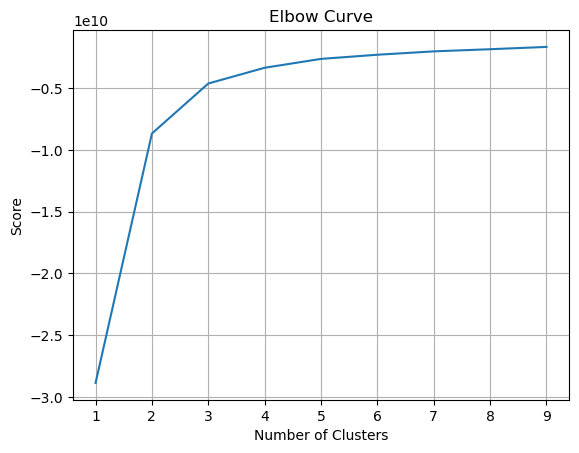

In [29]:
# plot the elbow 💪

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
plt.grid(True)
pl.show()

#### **K-MEANS CLUSTERING**

In [31]:
# create k-means object
kmeans = KMeans(n_clusters = 3) 

# fit the k-means object to the data
kmeans.fit(df_lego_num)

KMeans(n_clusters=3)

In [32]:
# create column in df with kmeans clusters
df_lego_num['cluster'] = kmeans.fit_predict(df_lego_num)

In [33]:
# confirm new column
df_lego_num.head()

,N.pieces,N.minifigs,ownedBy,wantedBy,rating,reviewCount,year,N.parts,N.colors,N.materials,N.spares,USnorm,UKnorm,CAnorm,DEnorm,PLnorm,avg_rp,cluster
19,6.0,1.0,1469.0,838,4.7,0,2023,6.0,2.0,1.0,2.0,0.00,0.0000,0.0000,0.0000,4.6774,0.94,0
21,812.0,0.0,2547.0,1819,4.3,0,2023,812.0,18.0,1.0,134.0,49.99,61.1864,55.2921,58.9882,64.9974,58.09,0
36,61.0,0.0,2454.0,227,3.4,1,2023,61.0,10.0,1.0,33.0,0.00,0.0000,0.0000,0.0000,0.0000,0.00,0
39,65.0,2.0,909.0,401,4.3,1,2023,65.0,14.0,1.0,42.0,9.99,12.2264,11.0521,11.7882,11.9574,11.40,0
59,83.0,0.0,1839.0,476,3.9,0,2023,83.0,8.0,1.0,36.0,0.00,0.0000,0.0000,0.0000,4.4174,0.88,0


In [34]:
# count observations per cluster
df_lego_num['cluster'].value_counts()

cluster
0    2195
1    1283
2     841
Name: count, dtype: int64

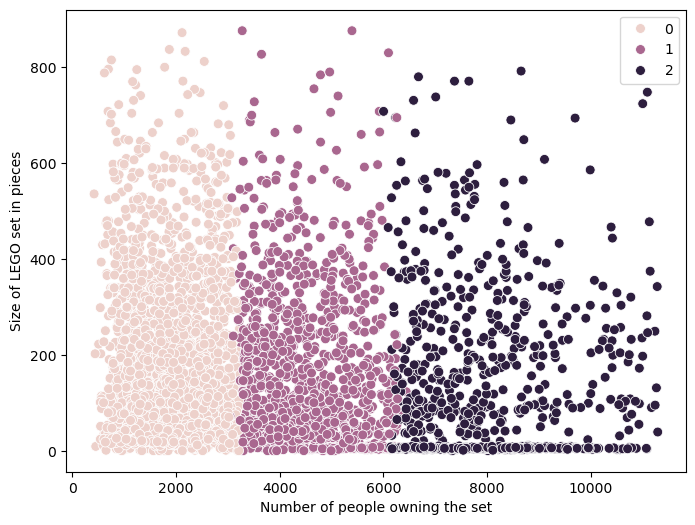

In [35]:
# plot the clusters 
plt.figure(figsize=(8,6))
ax1 = sns.scatterplot(x=df_lego_num['ownedBy'], y=df_lego_num['N.pieces'], hue=kmeans.labels_, s=50) 

ax1.grid(False)
plt.xlabel('Number of people owning the set') 
plt.ylabel('Size of LEGO set in pieces')
plt.show()

In [36]:
# check statistics by cluster size high to low: 1: 2202, 2: 1287, 0: 830
df_lego_num.groupby('cluster').agg({'N.pieces':['mean', 'median'], 
                                     'ownedBy':['mean', 'median'], 
                                   }).round(0).reindex([1, 2, 0])

N.pieces        ownedBy        
            mean median    mean  median
cluster                                
1          150.0   91.0  4525.0  4446.0
2          129.0   48.0  7999.0  7818.0
0          177.0  107.0  1880.0  1836.0

> **Observation**
> - Cluster 1 (purple) has the most observations, indicating that the dataset primarily contains larger sets with lower ownership counts.
> - There’s an inverse relationship between set size and ownership: smaller sets tend to have more owners, while larger sets have fewer owners.

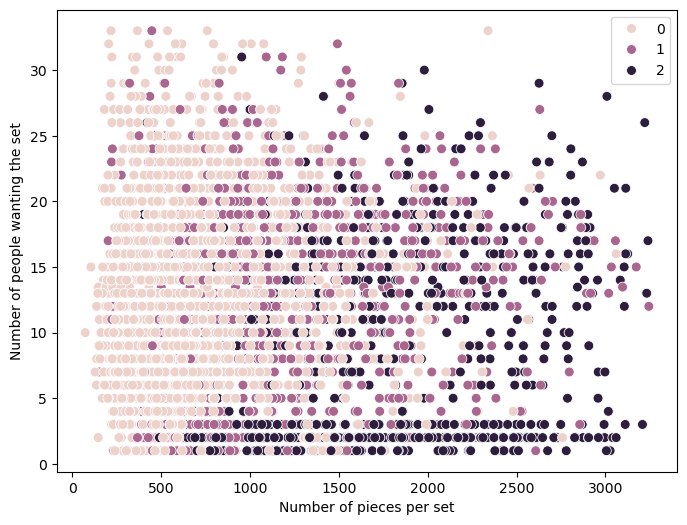

In [38]:
# plot the clusters 
plt.figure(figsize=(8,6))
ax2 = sns.scatterplot(x=df_lego_num['wantedBy'], y=df_lego_num['N.colors'], hue=kmeans.labels_, s=50) 

ax2.grid(False)
plt.xlabel('Number of pieces per set') 
plt.ylabel('Number of people wanting the set')
plt.show()

In [39]:
# check statistics by cluster size high to low: 1: 2202, 2: 1287, 0: 830
df_lego_num.groupby('cluster').agg({'wantedBy':['mean', 'median'], 
                                     'N.colors':['mean', 'median'], 
                                   }).round(0).reindex([1, 2, 0])

wantedBy         N.colors       
            mean  median     mean median
cluster                                 
1         1084.0   927.0     11.0   11.0
2         1720.0  1665.0      9.0    7.0
0          675.0   562.0     13.0   12.0

> **Observation**
> - Cluster 1 (purple) has the most observations, indicating that the least wanted sets are the most colorful ones. Where the next largest cluster 2 (dark purple) show the least colorful sets with the highest desirability. 
> - There’s a trend where simpler sets (fewer colors) are more popular, while more complex sets (more colors) tend to have lower interest.

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### **4. RESEARCH FINDINGS**

I only got useful clusters when combining LEGO attributes with customer behavior data, confirming that LEGO design aligns with customer desires in areas like accessibility (price, complexity, skill/age) and interest (theme, popularity, play style).
I would like to further explore this by types of play (ie. builders, role play, free build)